## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBClassifier

import eli5

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.3)
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv("Data/Covid Data.csv")

In [3]:
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


### EDA

In [4]:
df.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED',
       'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU'],
      dtype='object')

In [5]:
df["ICU"].value_counts()

97    848544
2     175685
1      16858
99      7488
Name: ICU, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

So we have all numerical data except one

In [7]:
df.nunique()

USMER                     2
MEDICAL_UNIT             13
SEX                       2
PATIENT_TYPE              2
DATE_DIED               401
INTUBED                   4
PNEUMONIA                 3
AGE                     121
PREGNANT                  4
DIABETES                  3
COPD                      3
ASTHMA                    3
INMSUPR                   3
HIPERTENSION              3
OTHER_DISEASE             3
CARDIOVASCULAR            3
OBESITY                   3
RENAL_CHRONIC             3
TOBACCO                   3
CLASIFFICATION_FINAL      7
ICU                       4
dtype: int64

Since all the others column such as age, Date died, clf & patient died are correctly represented

In [8]:
# Filter to separate columns with 2 and 4 values where it should have been only 2

for c in df.columns:
    if len(df[c].unique()) == 3 or len(df[c].unique()) == 4:
        print(f"{c}: {len(df[c].unique())}")

INTUBED: 4
PNEUMONIA: 3
PREGNANT: 4
DIABETES: 3
COPD: 3
ASTHMA: 3
INMSUPR: 3
HIPERTENSION: 3
OTHER_DISEASE: 3
CARDIOVASCULAR: 3
OBESITY: 3
RENAL_CHRONIC: 3
TOBACCO: 3
ICU: 4


In [9]:
for c in df.columns:
    if len(df[c].unique()) == 3 or len(df[c].unique()) == 4:
        print(df[c].value_counts(normalize=True)) #to understand the distn of data
        print("--"*50) # to get 150 dash lines

97    0.809235
2     0.151682
1     0.032097
99    0.006986
Name: INTUBED, dtype: float64
----------------------------------------------------------------------------------------------------
2     0.851188
1     0.133551
99    0.015262
Name: PNEUMONIA, dtype: float64
----------------------------------------------------------------------------------------------------
97    0.499259
2     0.489406
1     0.007754
98    0.003580
Name: PREGNANT, dtype: float64
----------------------------------------------------------------------------------------------------
2     0.877618
1     0.119199
98    0.003183
Name: DIABETES, dtype: float64
----------------------------------------------------------------------------------------------------
2     0.982772
1     0.014364
98    0.002864
Name: COPD, dtype: float64
----------------------------------------------------------------------------------------------------
2     0.967050
1     0.030109
98    0.002841
Name: ASTHMA, dtype: float64
---------------

## Clear Dataset

In [10]:
df["INTUBED"] = df['INTUBED'].replace(97,0)
df["INTUBED"] = df["INTUBED"].replace([2,99], 1)
df["PNEUMONIA"] = df["PNEUMONIA"].replace(2,0)
df["PNEUMONIA"] = df["PNEUMONIA"].replace(99,1)
df["PREGNANT"] = df["PREGNANT"].replace(97,0)
df["PREGNANT"] = df["PREGNANT"].replace([2,98],1)
df["DIABETES"] = df["DIABETES"].replace(2,0)
df["DIABETES"] = df["DIABETES"].replace(98,1)
df["COPD"] = df["COPD"].replace(2,0)
df["COPD"] = df["COPD"].replace(98,1)
df['ASTHMA'] = df['ASTHMA'].replace(2,0)
df['ASTHMA'] = df['ASTHMA'].replace(98,1)
df['INMSUPR'] = df['INMSUPR'].replace(2,0)
df['INMSUPR'] = df['INMSUPR'].replace(98,1)
df['HIPERTENSION'] = df['HIPERTENSION'].replace(2,0)
df['HIPERTENSION'] = df['HIPERTENSION'].replace(98,1)
df['OTHER_DISEASE'] = df['OTHER_DISEASE'].replace(2,0)
df['OTHER_DISEASE'] = df['OTHER_DISEASE'].replace(98,1)
df['CARDIOVASCULAR'] = df['CARDIOVASCULAR'].replace(2,0)
df['CARDIOVASCULAR'] = df['CARDIOVASCULAR'].replace(98,1)
df['OBESITY'] = df['OBESITY'].replace(2,0)
df['OBESITY'] = df['OBESITY'].replace(98,1)
df['TOBACCO'] = df['TOBACCO'].replace(2,0)
df['TOBACCO'] = df['TOBACCO'].replace(98,1)
df['ICU'] = df['ICU'].replace(97,0)
df['ICU'] = df['ICU'].replace([2,99],1)
df['RENAL_CHRONIC'] = df['RENAL_CHRONIC'].replace(2,0)
df['RENAL_CHRONIC'] = df['RENAL_CHRONIC'].replace(98,1)

## Plot Analysis

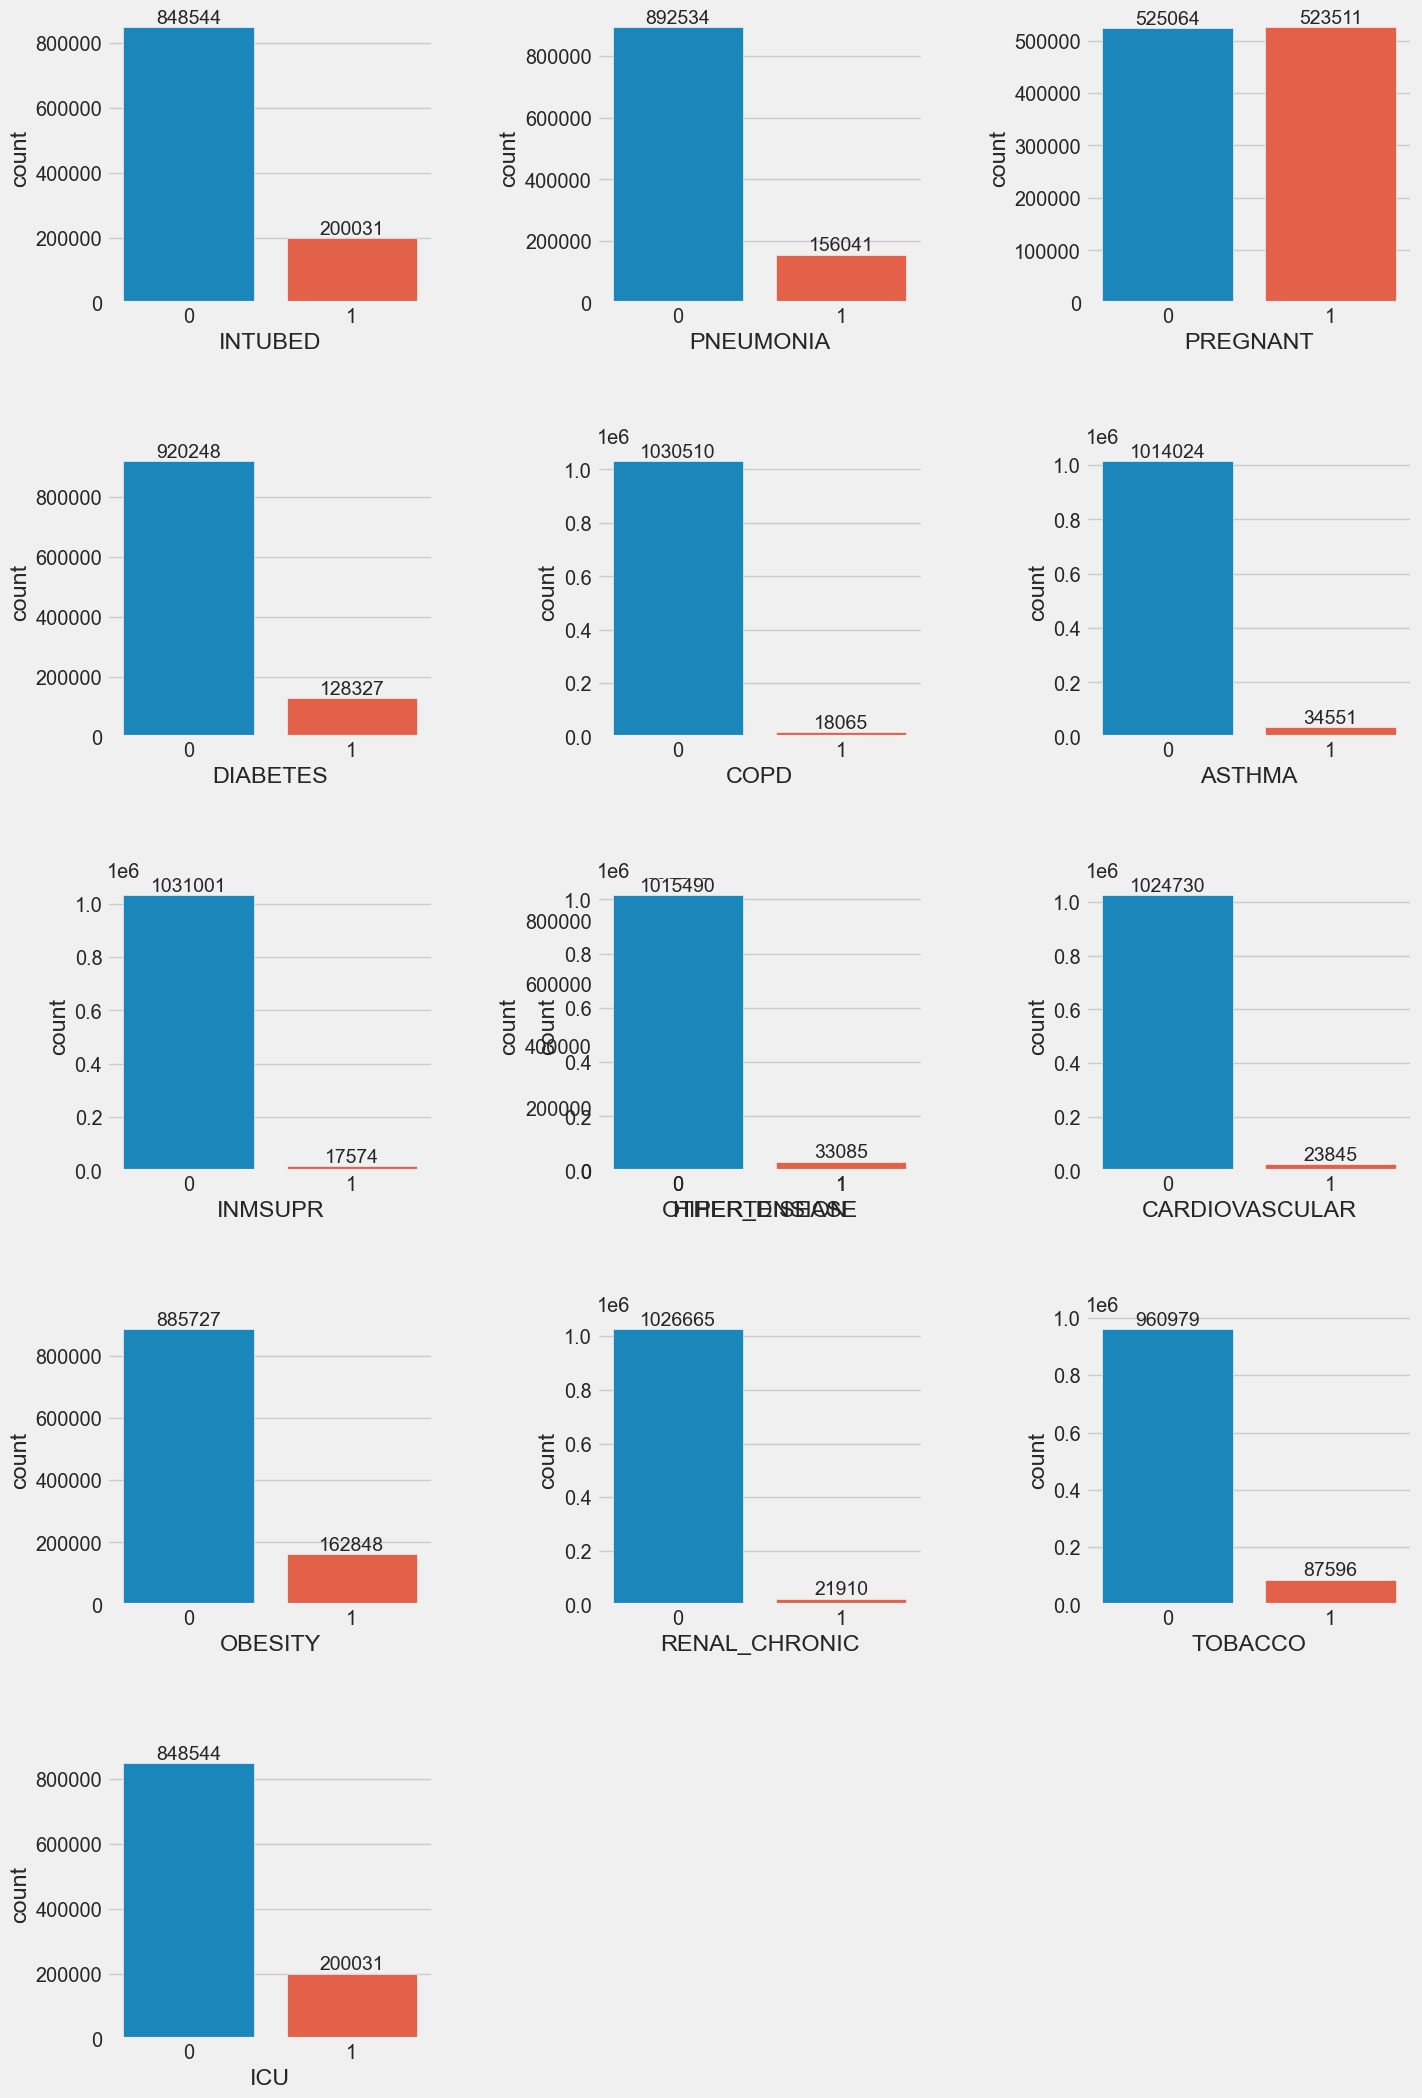

In [11]:
fig = plt.figure(figsize=(15,25))
fig.subplots_adjust(hspace=.5, wspace=.5)

ax = fig.add_subplot(5,3,1)
sns.countplot(df['INTUBED'])
abs_values = df['INTUBED'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

ax = fig.add_subplot(5,3,2)
sns.countplot(df['PNEUMONIA'])
abs_values = df['PNEUMONIA'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

ax = fig.add_subplot(5,3,3)
sns.countplot(df['PREGNANT'])
abs_values = df['PREGNANT'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

ax = fig.add_subplot(5,3,4)
sns.countplot(df['DIABETES'])
abs_values = df['DIABETES'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

ax = fig.add_subplot(5,3,5)
sns.countplot(df['COPD'])
abs_values = df['COPD'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

ax = fig.add_subplot(5,3,6)
sns.countplot(df['ASTHMA'])
abs_values = df['ASTHMA'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

ax = fig.add_subplot(5,3,7)
sns.countplot(df['INMSUPR'])
abs_values = df['INMSUPR'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

ax = fig.add_subplot(5,3,8)
sns.countplot(df['HIPERTENSION'])
abs_values = df['HIPERTENSION'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

ax = fig.add_subplot(5,3,8)
sns.countplot(df['OTHER_DISEASE'])
abs_values = df['OTHER_DISEASE'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

ax = fig.add_subplot(5,3,9)
sns.countplot(df['CARDIOVASCULAR'])
abs_values = df['CARDIOVASCULAR'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

ax = fig.add_subplot(5,3,10)
sns.countplot(df['OBESITY'])
abs_values = df['OBESITY'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

ax = fig.add_subplot(5,3,11)
sns.countplot(df['RENAL_CHRONIC'])
abs_values = df['RENAL_CHRONIC'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

ax = fig.add_subplot(5,3,12)
sns.countplot(df['TOBACCO'])
abs_values = df['TOBACCO'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

ax = fig.add_subplot(5,3,13)
sns.countplot(df['ICU'])
abs_values = df['ICU'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
plt.show()

## Survivors

In [12]:
df.DATE_DIED.value_counts()

9999-99-99    971633
06/07/2020      1000
07/07/2020       996
13/07/2020       990
16/06/2020       979
               ...  
24/11/2020         1
17/12/2020         1
08/12/2020         1
16/03/2021         1
22/04/2021         1
Name: DATE_DIED, Length: 401, dtype: int64

In [13]:
df["DEATH"] = [0 if each=="9999-99-99" else 1 for each in df.DATE_DIED]

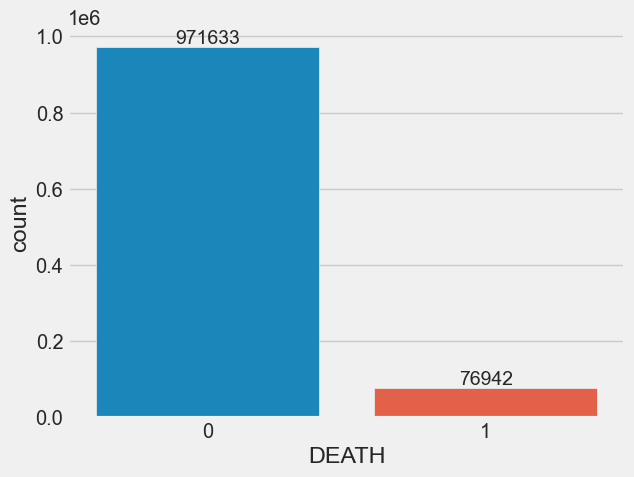

In [14]:
ax = sns.countplot(df["DEATH"]);
abs_values = df["DEATH"].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
plt.show()

## Median Age of cases

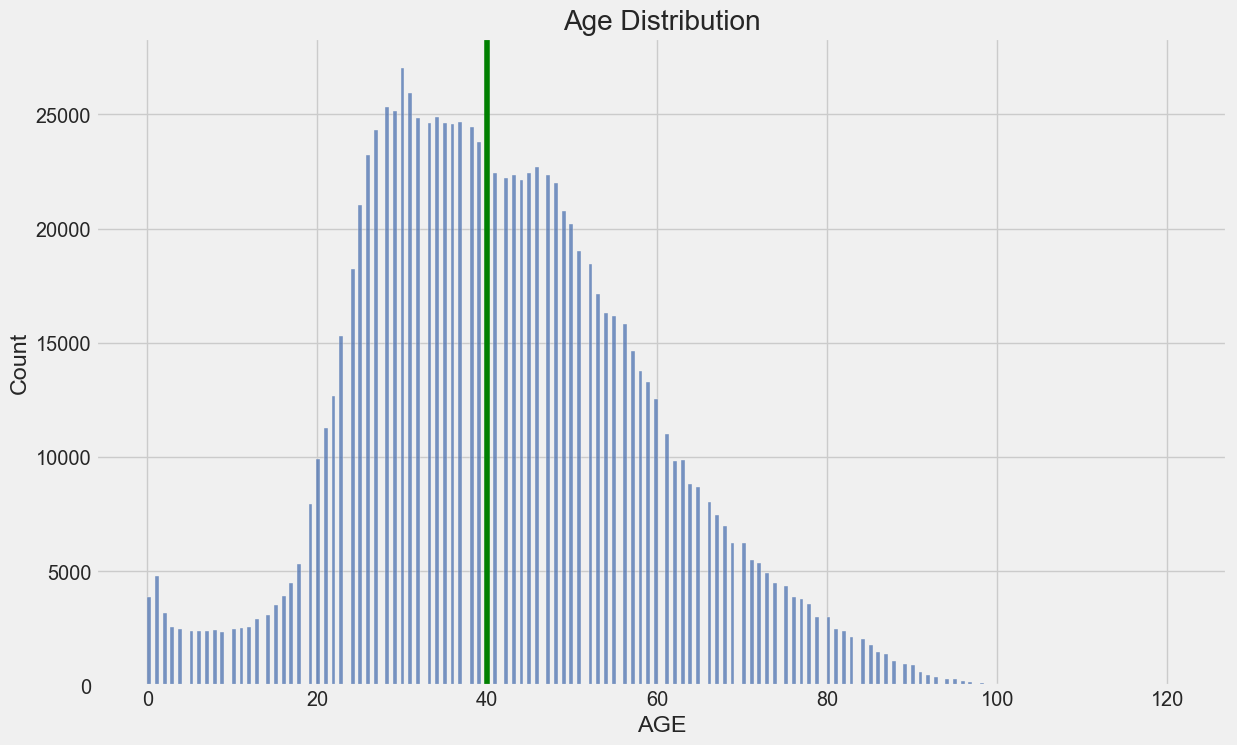

In [15]:
plt.figure(figsize=(13,8))
sns.histplot(x=df['AGE'])
plt.axvline(df['AGE'].median(), color='green') # Add a vertical green line across the Axes.
plt.title("Age Distribution");

## Correlation

Text(0.5, 1.0, 'Correlation Between Features')

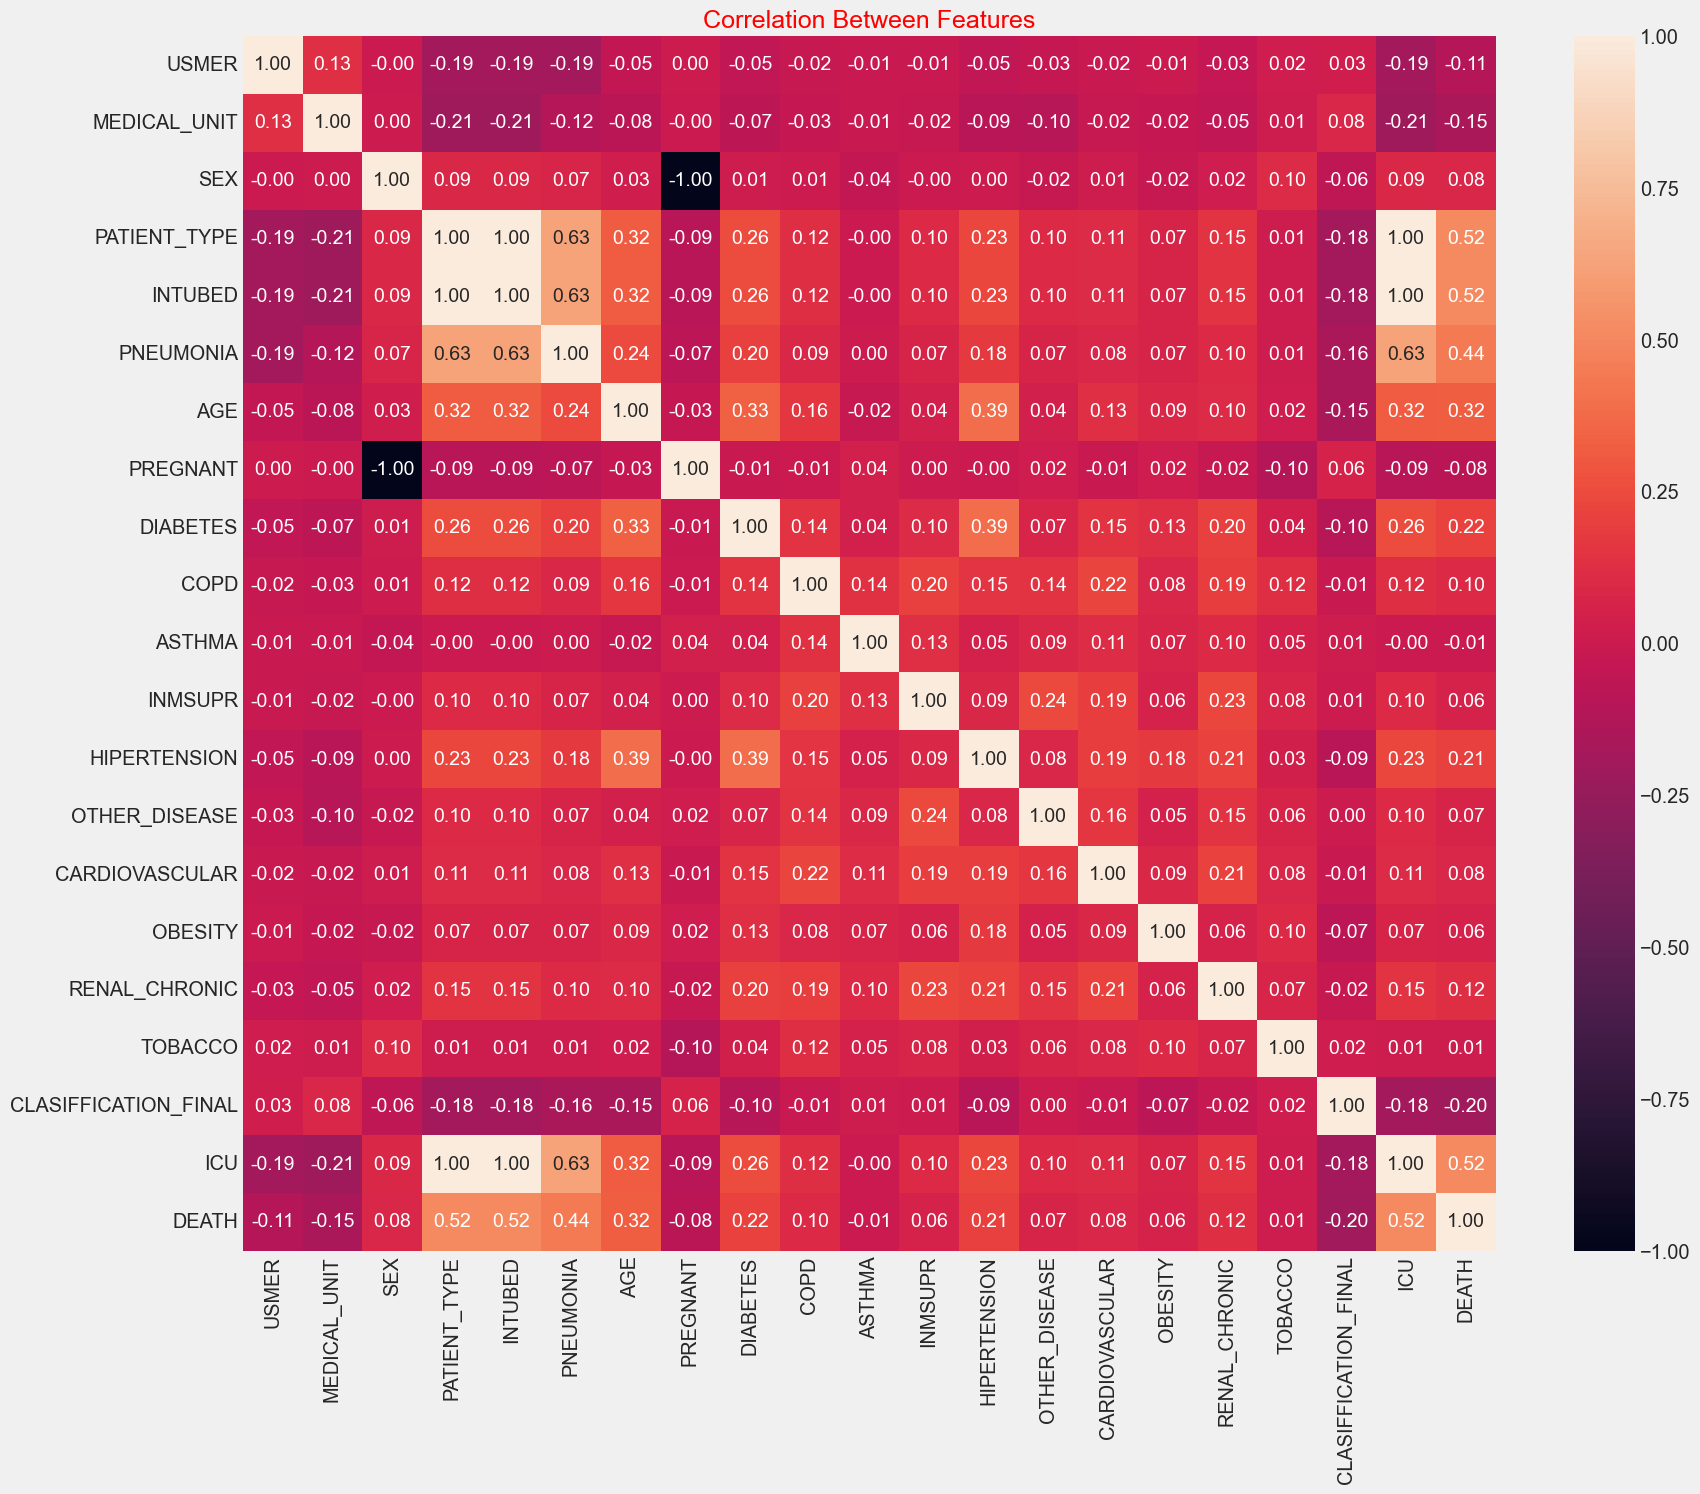

In [16]:
plt.figure(figsize=(18,15))
sns.heatmap(df.corr(),annot=True, fmt=".2f")
plt.title("Correlation Between Features",fontsize=18,color="red")

## Model

In [17]:


model = []
result = []



In [18]:


x = SelectKBest(chi2, k=10).fit_transform(df.drop(['DEATH','DATE_DIED'],axis=1), df['DEATH'])
y = df['DEATH']



In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [20]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1).fit(x_train, y_train)
vl = cross_val_score(clf, x_test, y_test, cv=10, n_jobs=-1)
print(round((vl.mean()*100),2))

model.append('GradientBoostingClassifier')
result.append(round((vl.mean()*100),2))

93.91


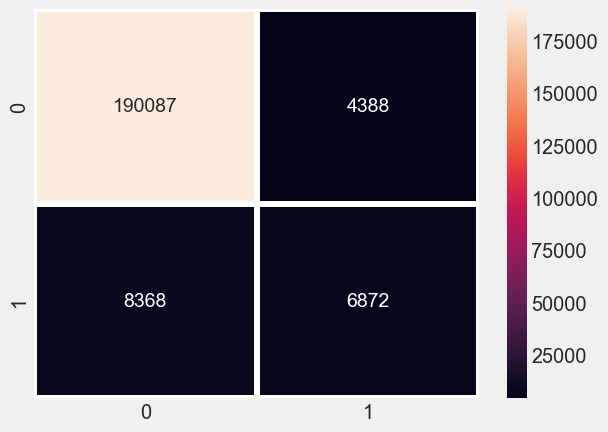

In [21]:
sns.heatmap(confusion_matrix(y_test, clf.predict(x_test)), annot=True, fmt=".0f",linewidths=4);

In [22]:


eli5.show_weights(clf)



Weight,Feature
0.7873 ± 0.2800,x2
0.1550 ± 0.3919,x3
0.0361 ± 0.8879,x4
0.0119 ± 0.9404,x8
0.0060 ± 0.8980,x0
0.0025 ± 0.3412,x5
0.0011 ± 0.1990,x7
0.0001 ± 0.1990,x9
0.0000 ± 0.1990,x6
0 ± 0.0000,x1


In [23]:
xgb = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1)
xgb.fit(x_train,y_train)
vl = cross_val_score(xgb, x_test,y_test, cv=10, n_jobs=-1)
print(round((vl.mean()*100),2))
model.append('XGBClassifier')
result.append(round((vl.mean()*100),2))

93.69


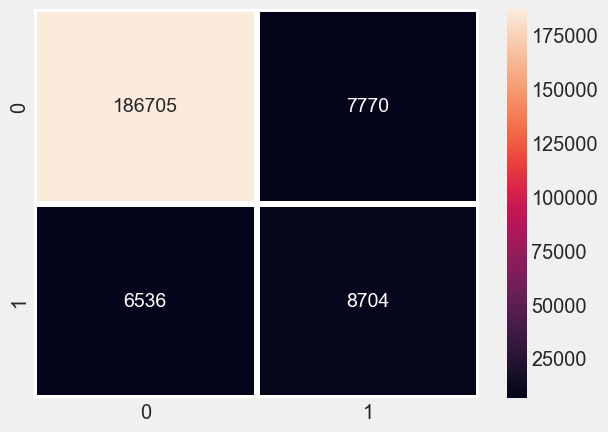

In [24]:
sns.heatmap(confusion_matrix(y_test, xgb.predict(x_test)), annot=True, fmt=".0f",linewidths=4);

In [25]:
eli5.show_weights(xgb)

Weight,Feature
0.6873,f1
0.1888,f4
0.1051,f8
0.0188,f3
0,f9
0,f7
0,f6
0,f5
0,f2
0,f0


## Data Balancing

Under-sample the majority class by randomly picking samples with or without replacement.

In [26]:
from imblearn.under_sampling import RandomUnderSampler

In [27]:


rus = RandomUnderSampler()
x_resampled,y_resampled = rus.fit_resample(x,y)



In [28]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)

In [29]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1).fit(x_train, y_train)
vl = cross_val_score(clf, x_test, y_test, cv=10, n_jobs=-1)
print(round((vl.mean()*100),2))

model.append('GradientBoostingClassifier RandomUnderSampler')
result.append(round((vl.mean()*100),2))

90.48


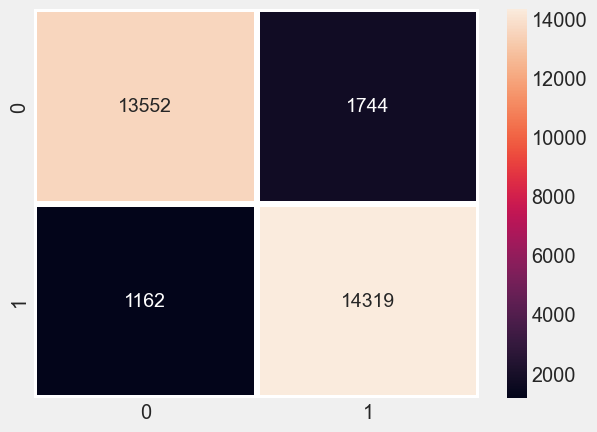

In [30]:
sns.heatmap(confusion_matrix(y_test, clf.predict(x_test)), annot=True, fmt=".0f",linewidths=4);

In [31]:
eli5.show_weights(clf)

Weight,Feature
0.8637 ± 0.2800,x2
0.0738 ± 0.8417,x4
0.0339 ± 0.3919,x3
0.0151 ± 0.7684,x8
0.0103 ± 0.9998,x0
0.0019 ± 0.1990,x7
0.0011 ± 0.1990,x5
0.0002 ± 0.1990,x1
0.0000 ± 0.1990,x6
0 ± 0.0000,x9


In [32]:
xgb = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1)
xgb.fit(x_train,y_train)
vl = cross_val_score(xgb, x_test,y_test, cv=10, n_jobs=-1)
print(round((vl.mean()*100),2))

model.append('XGBClassifier RandomUnderSampler')
result.append(round((vl.mean()*100),2))

90.25


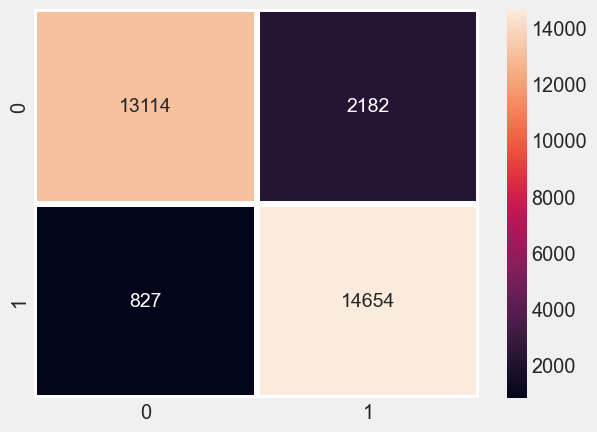

In [33]:
sns.heatmap(confusion_matrix(y_test, xgb.predict(x_test)), annot=True, fmt=".0f",linewidths=4);

In [34]:
eli5.show_weights(xgb)

Weight,Feature
0.7839,f1
0.1018,f3
0.0861,f4
0.0281,f8
0,f9
0,f7
0,f6
0,f5
0,f2
0,f0


## Conclusion

In [35]:
df_result = pd.DataFrame()
df_result['model'] = model
df_result['acc'] = result

df_result.sort_values(by=['acc'], ascending=False)

,model,acc
0,GradientBoostingClassifier,93.91
1,XGBClassifier,93.69
2,GradientBoostingClassifier RandomUnderSampler,90.48
3,XGBClassifier RandomUnderSampler,90.25
